# Working with non-detector data

The biggest and often most important data at European XFEL comes from X-ray pixel detectors,
but there are many other data sources which may be of interest.
This data is often small enough to load it completely into memory, making it much easier to work with.

In [1]:
%matplotlib inline
from karabo_data import RunDirectory
import matplotlib.pyplot as plt
import numpy as np
import re
import xarray as xr

## Using pandas

This example works with data from two X-Ray Gas Monitors (XGMs).
These measure properties of the X-ray beam in different parts of the tunnel.
This data refers to one XGM in XTD2 and one in XTD9.

We create a pandas dataframe containing the beam x and y position at each XGM, and the photon flux. We select the columns using 'glob' patterns: `*` is a wildcard matching anything.

[pandas](http://pandas.pydata.org/pandas-docs/stable/) makes it very convenient to work with tabular data like this, though we're limited to datasets that have a single value per train.

In [2]:
run = RunDirectory('/gpfs/exfel/exp/SA1/201830/p900025/raw/r0150/')

In [3]:
df = run.get_dataframe(fields=[("*_XGM/*", "*.i[xy]Pos"), ("*_XGM/*", "*.photonFlux")])
df.head()

,SA1_XTD2_XGM/XGM/DOOCS/beamPosition.ixPos,SA1_XTD2_XGM/XGM/DOOCS/beamPosition.iyPos,SA1_XTD2_XGM/XGM/DOOCS/pulseEnergy.photonFlux,SPB_XTD9_XGM/XGM/DOOCS/beamPosition.ixPos,SPB_XTD9_XGM/XGM/DOOCS/beamPosition.iyPos,SPB_XTD9_XGM/XGM/DOOCS/pulseEnergy.photonFlux
trainId,,,,,,
142844490,2.035218,0.161399,1410.723755,-2.277912,1.717195,1327.06958
142844491,2.035218,0.161399,1410.137451,-2.277912,1.717195,1327.06958
142844492,2.035218,0.161399,1410.137451,-2.277912,1.717195,1327.06958
142844493,2.035218,0.161399,1410.137451,-2.277912,1.717195,1327.06958
142844494,2.035218,0.161399,1410.137451,-2.277912,1.717195,1327.06958


We can now make plots to compare the parameters at the two XGM positions.
As expected, there's a strong correlation for each parameter.

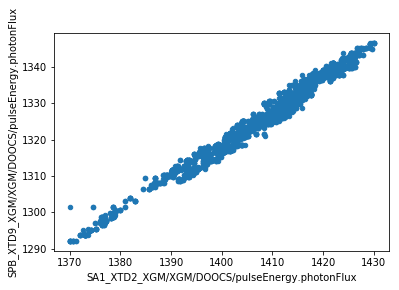

In [4]:
df.plot.scatter(x='SA1_XTD2_XGM/XGM/DOOCS/pulseEnergy.photonFlux', y='SPB_XTD9_XGM/XGM/DOOCS/pulseEnergy.photonFlux')

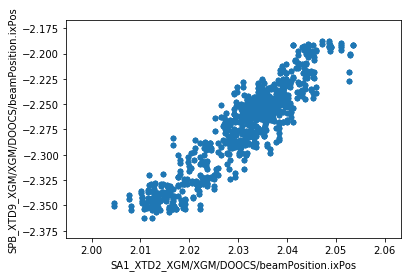

In [5]:
ax = df.plot.scatter(x='SA1_XTD2_XGM/XGM/DOOCS/beamPosition.ixPos', y='SPB_XTD9_XGM/XGM/DOOCS/beamPosition.ixPos')

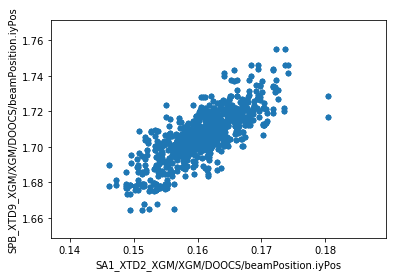

In [6]:
ay = df.plot.scatter(x='SA1_XTD2_XGM/XGM/DOOCS/beamPosition.iyPos', y='SPB_XTD9_XGM/XGM/DOOCS/beamPosition.iyPos')

We can also export the dataframe to a CSV file - or [any other format pandas supports](http://pandas.pydata.org/pandas-docs/stable/io.html) - for further analysis with other tools.

In [7]:
df.to_csv('xtd2_xtd9_xgm_r150.csv')

## Using xarray

[xarray](https://xarray.pydata.org/en/stable/) adds pandas-style axis labelling to multidimensional numpy arrays.
We can get xarray arrays for data which has multiple values per train.
For example, the Photo-Electron Spectrometer (PES) is a monitoring device which records energy spectra for each train.
Here's the data from one of its 16 spectrometers:

In [8]:
run = RunDirectory('/gpfs/exfel/exp/SA3/201830/p900027/raw/r0067/')

In [9]:
run.get_array('SA3_XTD10_PES/ADC/1:network', 'digitizers.channel_4_A.raw.samples')

<xarray.DataArray (trainId: 1475, dim_0: 40000)>
array([[ -6, -10,  -7, ..., -10,  -8,  -9],
       [ -8,  -8,  -7, ...,  -9,  -2, -11],
       [ -8, -10,  -7, ...,  -6,  -8, -11],
       ..., 
       [ -7,  -9,  -8, ...,  -9,  -2,  -5],
       [ -5, -10,  -8, ...,  -5,  -4, -10],
       [ -7,  -8,  -7, ...,  -6,  -5,  -8]], dtype=int16)
Coordinates:
  * trainId  (trainId) uint64 128146446 128146447 128146448 128146449 ...
Dimensions without coordinates: dim_0

The PES consists of 16 spectrometers arranged in a circle around the beamline. We'll retrieve the data for two of these, separated by 90&deg;. N and E refer to their positions in the circle, although these are not literally North and East.

The [xarray.align()](http://xarray.pydata.org/en/stable/generated/xarray.align.html) function aligns data using the axes.
This is important if you're comparing data from different sources, because it matches up the train IDs.
By specifying `join='inner'`, we keep only the trains which have data in both sets.

In [10]:
data_n = run.get_array('SA3_XTD10_PES/ADC/1:network', 'digitizers.channel_4_A.raw.samples')
data_e = run.get_array('SA3_XTD10_PES/ADC/1:network', 'digitizers.channel_3_A.raw.samples')
data_n, data_e = xr.align(data_n, data_e, join='inner')
nsamples = data_n.shape[1]
data_n.shape

(1475, 40000)

We'll get a few other values from slow data to annotate the plot.

In [11]:
# Get the first values from four channels measuring voltage
electr = run.get_dataframe([('SA3_XTD10_PES/MCPS/MPOD', 'channels.U20[0123].measurementSenseVoltage')])
electr_voltages = electr.iloc[0].sort_index()
electr_voltages

SA3_XTD10_PES/MCPS/MPOD/channels.U200.measurementSenseVoltage   -0.101792
SA3_XTD10_PES/MCPS/MPOD/channels.U201.measurementSenseVoltage   -0.111782
SA3_XTD10_PES/MCPS/MPOD/channels.U202.measurementSenseVoltage   -0.106823
SA3_XTD10_PES/MCPS/MPOD/channels.U203.measurementSenseVoltage   -0.107910
Name: 128146446, dtype: float32

In [12]:
gas_interlocks = run.get_dataframe([('SA3_XTD10_PES/DCTRL/*', 'interlock.AActionState')])

# Take the first row of the gas interlock data and find which gas was unlocked
row = gas_interlocks.iloc[0]
print(row)
if (row == 0).any():
    key = row[row == 0].index[0]
    target_gas = re.search(r'(XENON|KRYPTON|NITROGEN|NEON)', key).group(1).title()
else:
    target_gas = 'No gas'

SA3_XTD10_PES/DCTRL/V30300S_NITROGEN/interlock.AActionState    1
SA3_XTD10_PES/DCTRL/V30320S_KRYPTON/interlock.AActionState     1
SA3_XTD10_PES/DCTRL/V30310S_NEON/interlock.AActionState        0
SA3_XTD10_PES/DCTRL/V30330S_XENON/interlock.AActionState       1
Name: 128146446, dtype: uint32


Now we can average the spectra across the trains in this run, and plot them.

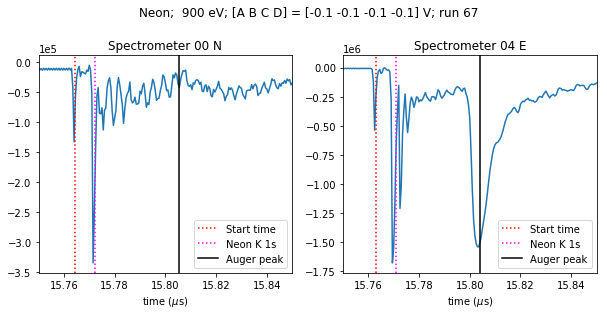

In [14]:
x = np.linspace(0, 0.0005*nsamples, nsamples, endpoint=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, dataset, start_time in zip(axes, [data_n, data_e], [15.76439411, 15.76289411]):
    ax.plot(x, dataset.sum(axis=0))
    ax.yaxis.major.formatter.set_powerlimits((0, 0))
    ax.set_xlim(15.75, 15.85)
    ax.set_xlabel('time ($\mu$s)')

    ax.axvline(start_time, color='red', linestyle='dotted', label='Start time')
    ax.axvline(start_time + 0.0079, color='magenta', linestyle='dotted', label='Neon K 1s')
    ax.axvline(start_time + 0.041, color='black', label='Auger peak')
    ax.legend()

axes[0].set_title('Spectrometer 00 N')
axes[1].set_title('Spectrometer 04 E')
fig.suptitle('{gas};  900 eV; [A B C D] = [{voltages[0]:.1f} {voltages[1]:.1f} {voltages[2]:.1f} {voltages[3]:.1f}] V; run 67'
             .format(gas=target_gas, voltages=electr_voltages.values), y=1.05);

The spectra look different because the beam is horizontally polarised, so the E spectrometer sees a peak that the N spectrometer doesn't.